# Computing matrix elements with Heller-type Gaussian wavepackets

## Table of Content <a name="TOC"></a>

1. [General setups](#setups)
2. [Plotting the Gaussian wavepackets with `gwp_value` function](#plotting_gwp)

  2.1. [1D Gaussian wavepacket](#1d_plotting)
  
  2.2. [2D Gaussian wavepacket](#2d_plotting)
   
3. [Computing overlaps of Gaussian wavepackets with `gwp_overlap` function](#gwp_overlap)
4. [Computing transition dipole moment with `gwp_dipole` function](#gwp_dipole)
5. [Computing derivative coupling matrix elements with `gwp_coupling` function](#gwp_coupling)
6. [Computing the kinetic energy matrix elements with `gwp_kinetic` function](#gwp_kinetic)


### A. Learning objectives

- to compute various types of matrix elements involving Gaussian wavepackets
- to visualize 1D and 2D properties of Gaussian wavepackets
- to predict how computed properties depend on parameters of the Gaussian wavepacket
- to be able to tell the difference between quantum and classical kinetic energies of a Gaussian wavepacket
- to argument the conceptual flaw of considering classical particles as a zero-width limit of Gaussian wavepackets

### B. Use cases

- [Plotting 1D wavepackets](#1d_plotting)
- [Plotting 2D wavepackets](#2d_plotting)
- [Computing overlaps of Heller's wavepeckets](#gwp_overlap)
- [Computing transition dipole matrix elements with Heller's wavepeckets](#gwp_dipole)
- [Computing derivative coupling matrix elements with Heller's wavepeckets](#gwp_coupling)
- [Computing kinetic energy operator matrix elements with Heller's wavepeckets](#gwp_kinetic)


### C. Functions

- `liblibra::libdyn::libgwp`
  - [`gwp_coupling`](#gwp_coupling_function)    
  - [`gwp_dipole`](#gwp_dipole_function)
  - [`gwp_kinetic`](#gwp_kinetic_function)
  - [`gwp_overlap`](#gwp_overlap_function)
  - [`gwp_value`](#gwp_value)
    
- `libra_py`
  - `data_visualize`
   - [`plot_map`](#plot_map)      

### D. Classes and class members
    
    None

### 1. General setups
<a name="setups"></a>[Back to TOC](#TOC)

First, lets import all the necessary libraries and define all the variables that we may need

In [1]:
import os
import math
import sys
import numpy as np

# Fisrt, we add the location of the library to test to the PYTHON path
if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *
from libra_py import *

/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/miniconda2/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::all

Also, lets import matplotlib for plotting and define all the plotting parameters: sizes, colors, etc.

In [2]:
import matplotlib.pyplot as plt   # plots
from scipy.interpolate import griddata

%matplotlib inline 


plt.rc('axes', titlesize=38)      # fontsize of the axes title
plt.rc('axes', labelsize=38)      # fontsize of the x and y labels
plt.rc('legend', fontsize=38)     # legend fontsize
plt.rc('xtick', labelsize=38)    # fontsize of the tick labels
plt.rc('ytick', labelsize=38)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"]

### 2. Plotting the Gaussian wavepackets with `gwp_value` function
<a name="gwp_value"></a><a name="plotting_gwp"></a>[Back to TOC](#TOC)


This function computes the value of a multidimensional Gaussian at a given point r

$
G_a(r; R_a, P_a, \alpha_a, \gamma_a) = (\frac{2 \alpha_a}{\pi})^{\frac{Ndof}{4}} exp[-\alpha_a (r-R_a)^2 + \frac{i P_a}{\hbar} (r-R_a) + \frac{i \gamma_a}{\hbar}]$

It follows the C++ signature:

    complex<double> gwp_value(MATRIX& r, MATRIX& R, MATRIX& P, double gamma,  double alp, double hbar)
       
The parameters are as follows:

  * `R` (MATRIX(Ndof x 1)) - multidimensional coordinate of the center of the Gaussian. 
  * `P` (MATRIX(Ndof x 1)) - multidimensional momentum (classical) of the center of the Gaussian. 
  * `gamma` (double) - phase of the overall Gaussian
  * `alp` (double) - the Gaussian width factor. Assumed to be the same for all components of the multidimensional Gaussians
  * `hbar` (double) - the Planck constant in selected units

  The function returns the value of the Gaussian function - a complex number
  
Look for derivations [here](https://github.com/alexvakimov/Derivatory/blob/master/Gaussian_wavepackets.pdf)

### 2.1. 1D model
<a name="gwp_value"></a><a name="1d_plotting"></a>[Back to TOC](#TOC)

Lets setup a 1D grid and compute the wavepacket amplitudes at all grid points

In [3]:
hbar = 1.0
alpha = 1.0
gamma = 0.5
P = MATRIX(1,1); P.set(0, 0, 1.0)
R = MATRIX(1,1); R.set(0, 0, -1.0)
r = MATRIX(1,1);

x_grid = []
for i in range(200):
    x_grid.append(-10.0 + 0.1*i)
    
g_re, g_im = [], []
for x in x_grid:
    r.set(0, 0, x)
    g_val = gwp_value(r, R, P, gamma, alpha, hbar)
    g_re.append( g_val.real )
    g_im.append( g_val.imag )

Plot the results

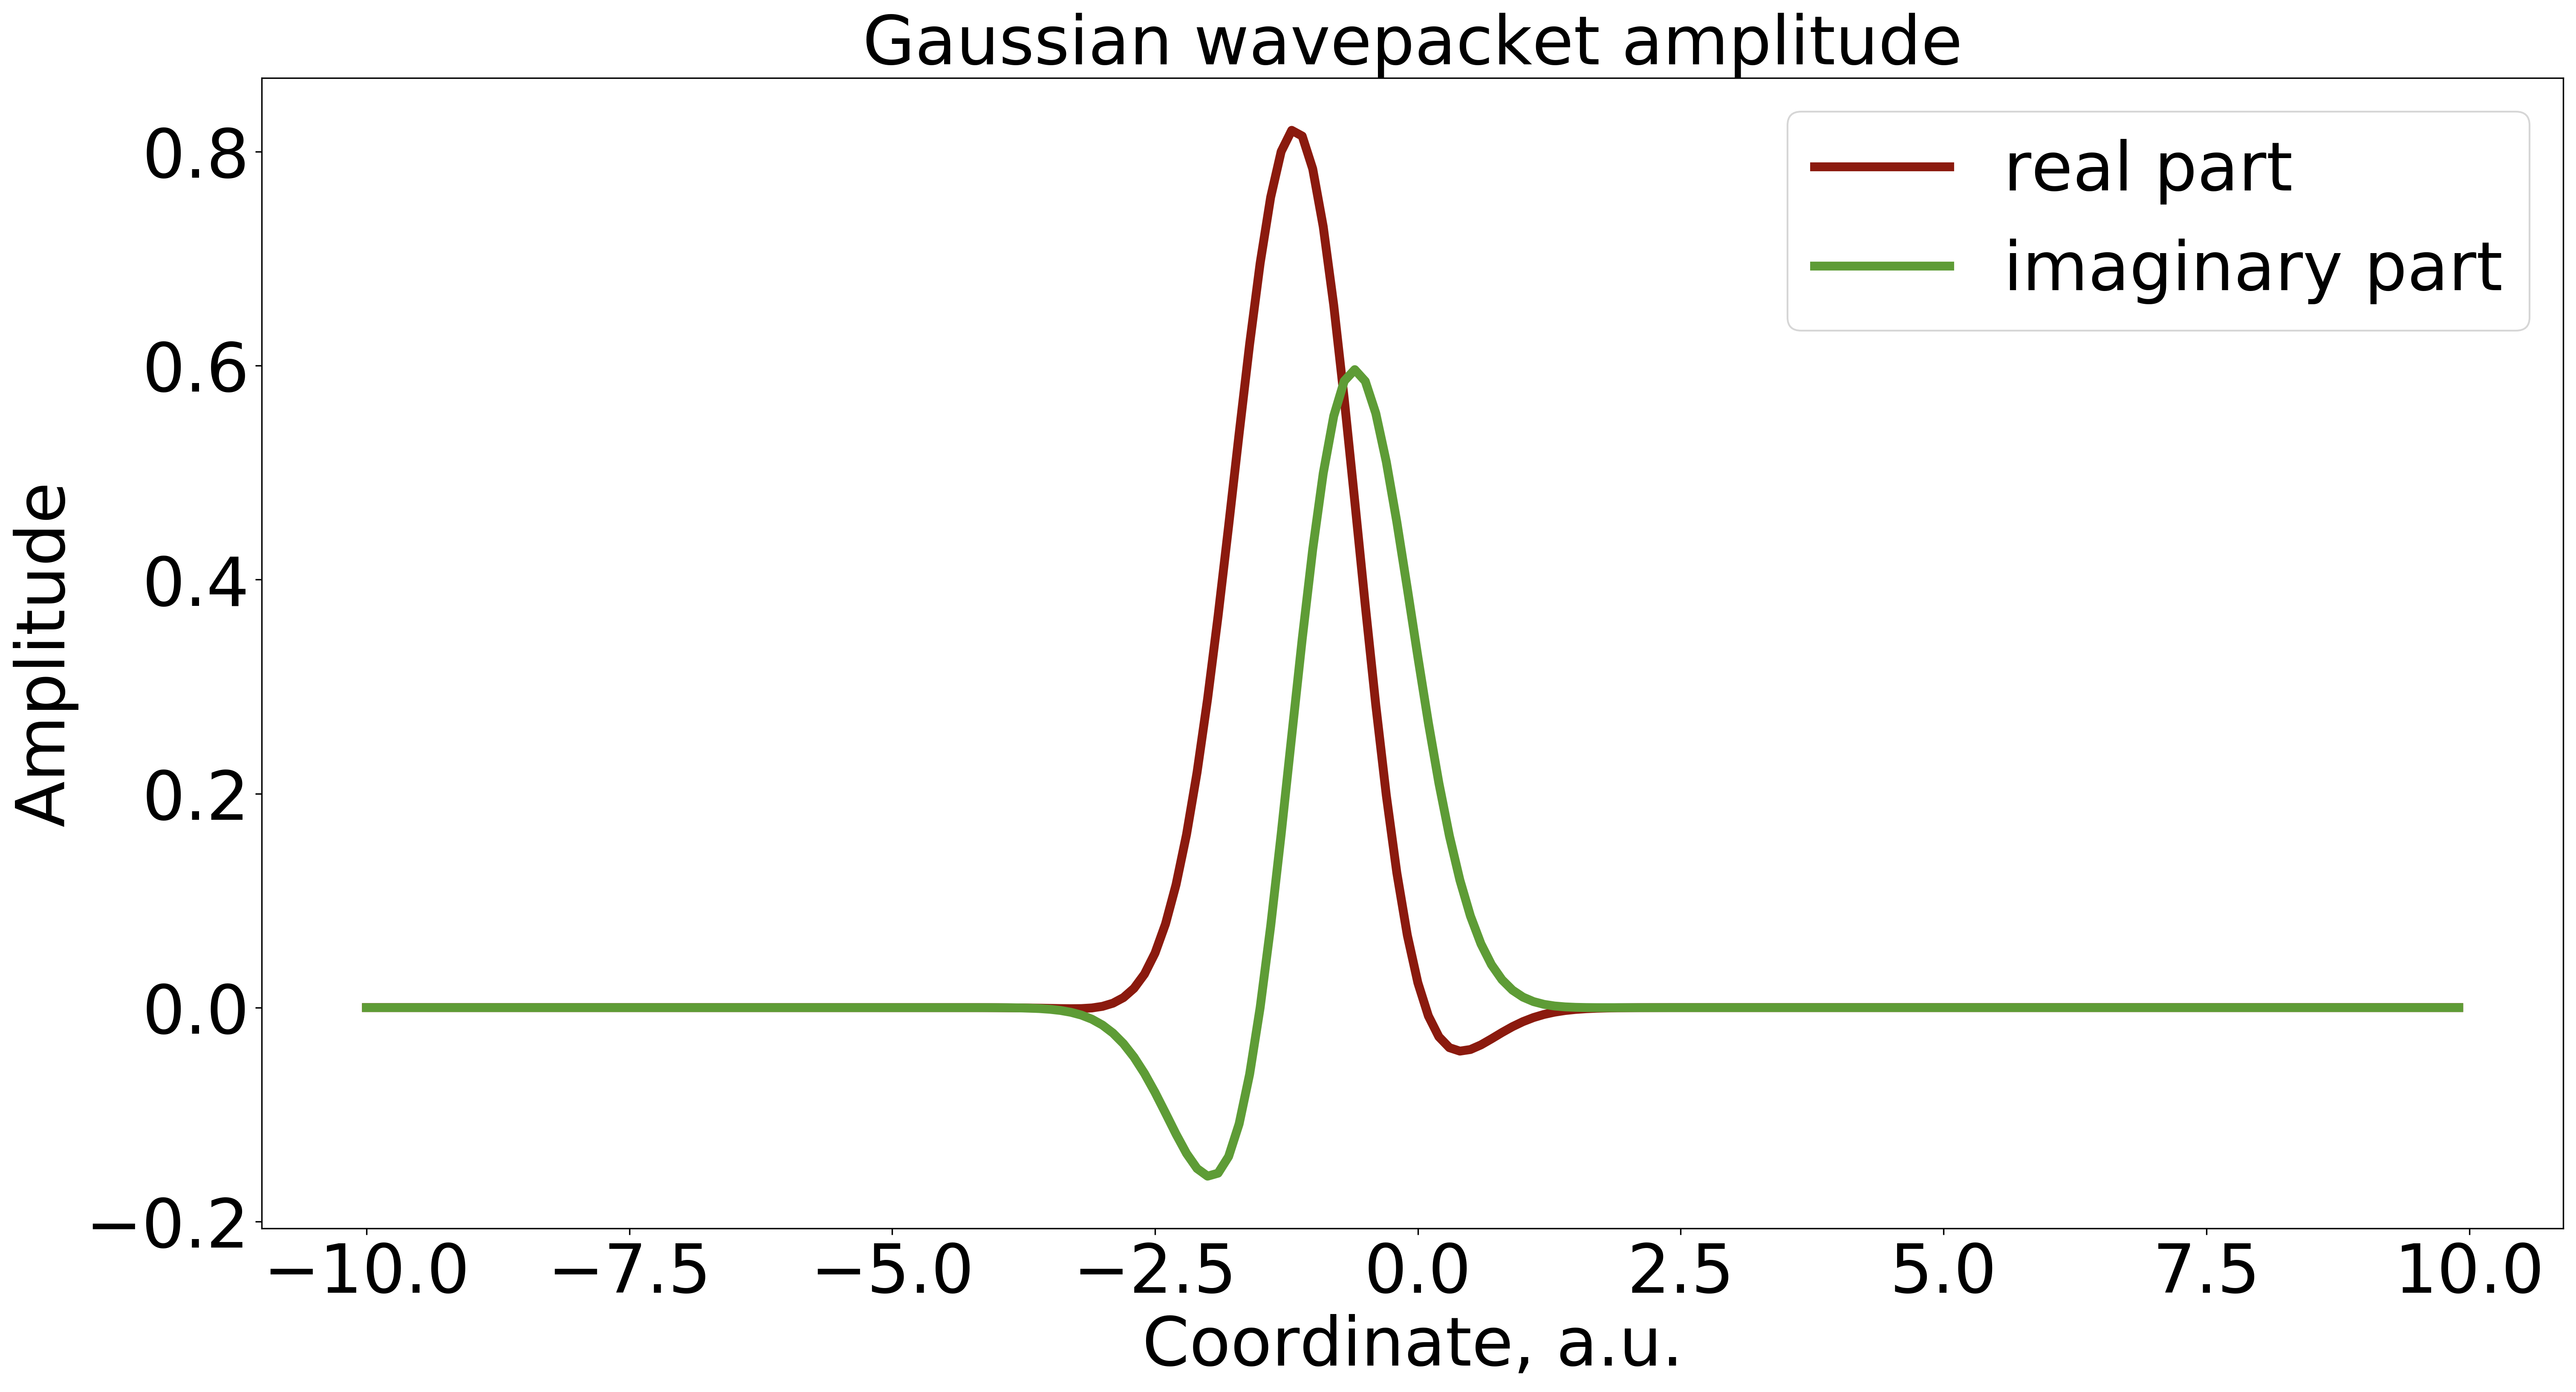

In [4]:
plt.figure(1, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Gaussian wavepacket amplitude')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Amplitude')

plt.plot(x_grid, g_re , label='real part', linewidth=5, color = colors["11"]) 
plt.plot(x_grid, g_im , label='imaginary part', linewidth=5, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()

### Exercise 1
Play around with the parameters of the wavepacket:
* $\alpha$ (`alp`)
* $\gamma$ (`gamma`)
* $R$ (`R`)
* $P$ (`P`)

What property of the GWP does each parameter define?

### 2.2. 2D model
<a name="gwp_value"></a><a name="2d_plotting"></a>[Back to TOC](#TOC)

Lets setup a 2D grid and compute the wavepacket amplitudes at all grid points

In [5]:
hbar = 1.0
alpha = 1.0
gamma = 0.5
P = MATRIX(2,1); P.set(0, 0, 1.0);  P.set(1, 0, 0.0)
R = MATRIX(2,1); R.set(0, 0, -1.0); R.set(1, 0, 0.0)
r = MATRIX(2,1);

x_grid, y_grid = [], []
for i in range(50):
    x_grid.append(-5.0 + 0.2*i)
    y_grid.append(-5.0 + 0.2*i)
    
g_re, g_im = [], []
for x in x_grid:
    g_re_x, g_im_x = [], []
    for y in y_grid:
        
        r.set(0, 0, x)
        r.set(1, 0, y)
    
        g_val = gwp_value(r, R, P, gamma, alpha, hbar)
        g_re_x.append( g_val.real )
        g_im_x.append( g_val.imag )
        
    g_re.append(g_re_x)
    g_im.append(g_im_x)

Plot the results
<a name="plot_map"></a>

No handles with labels found to put in legend.


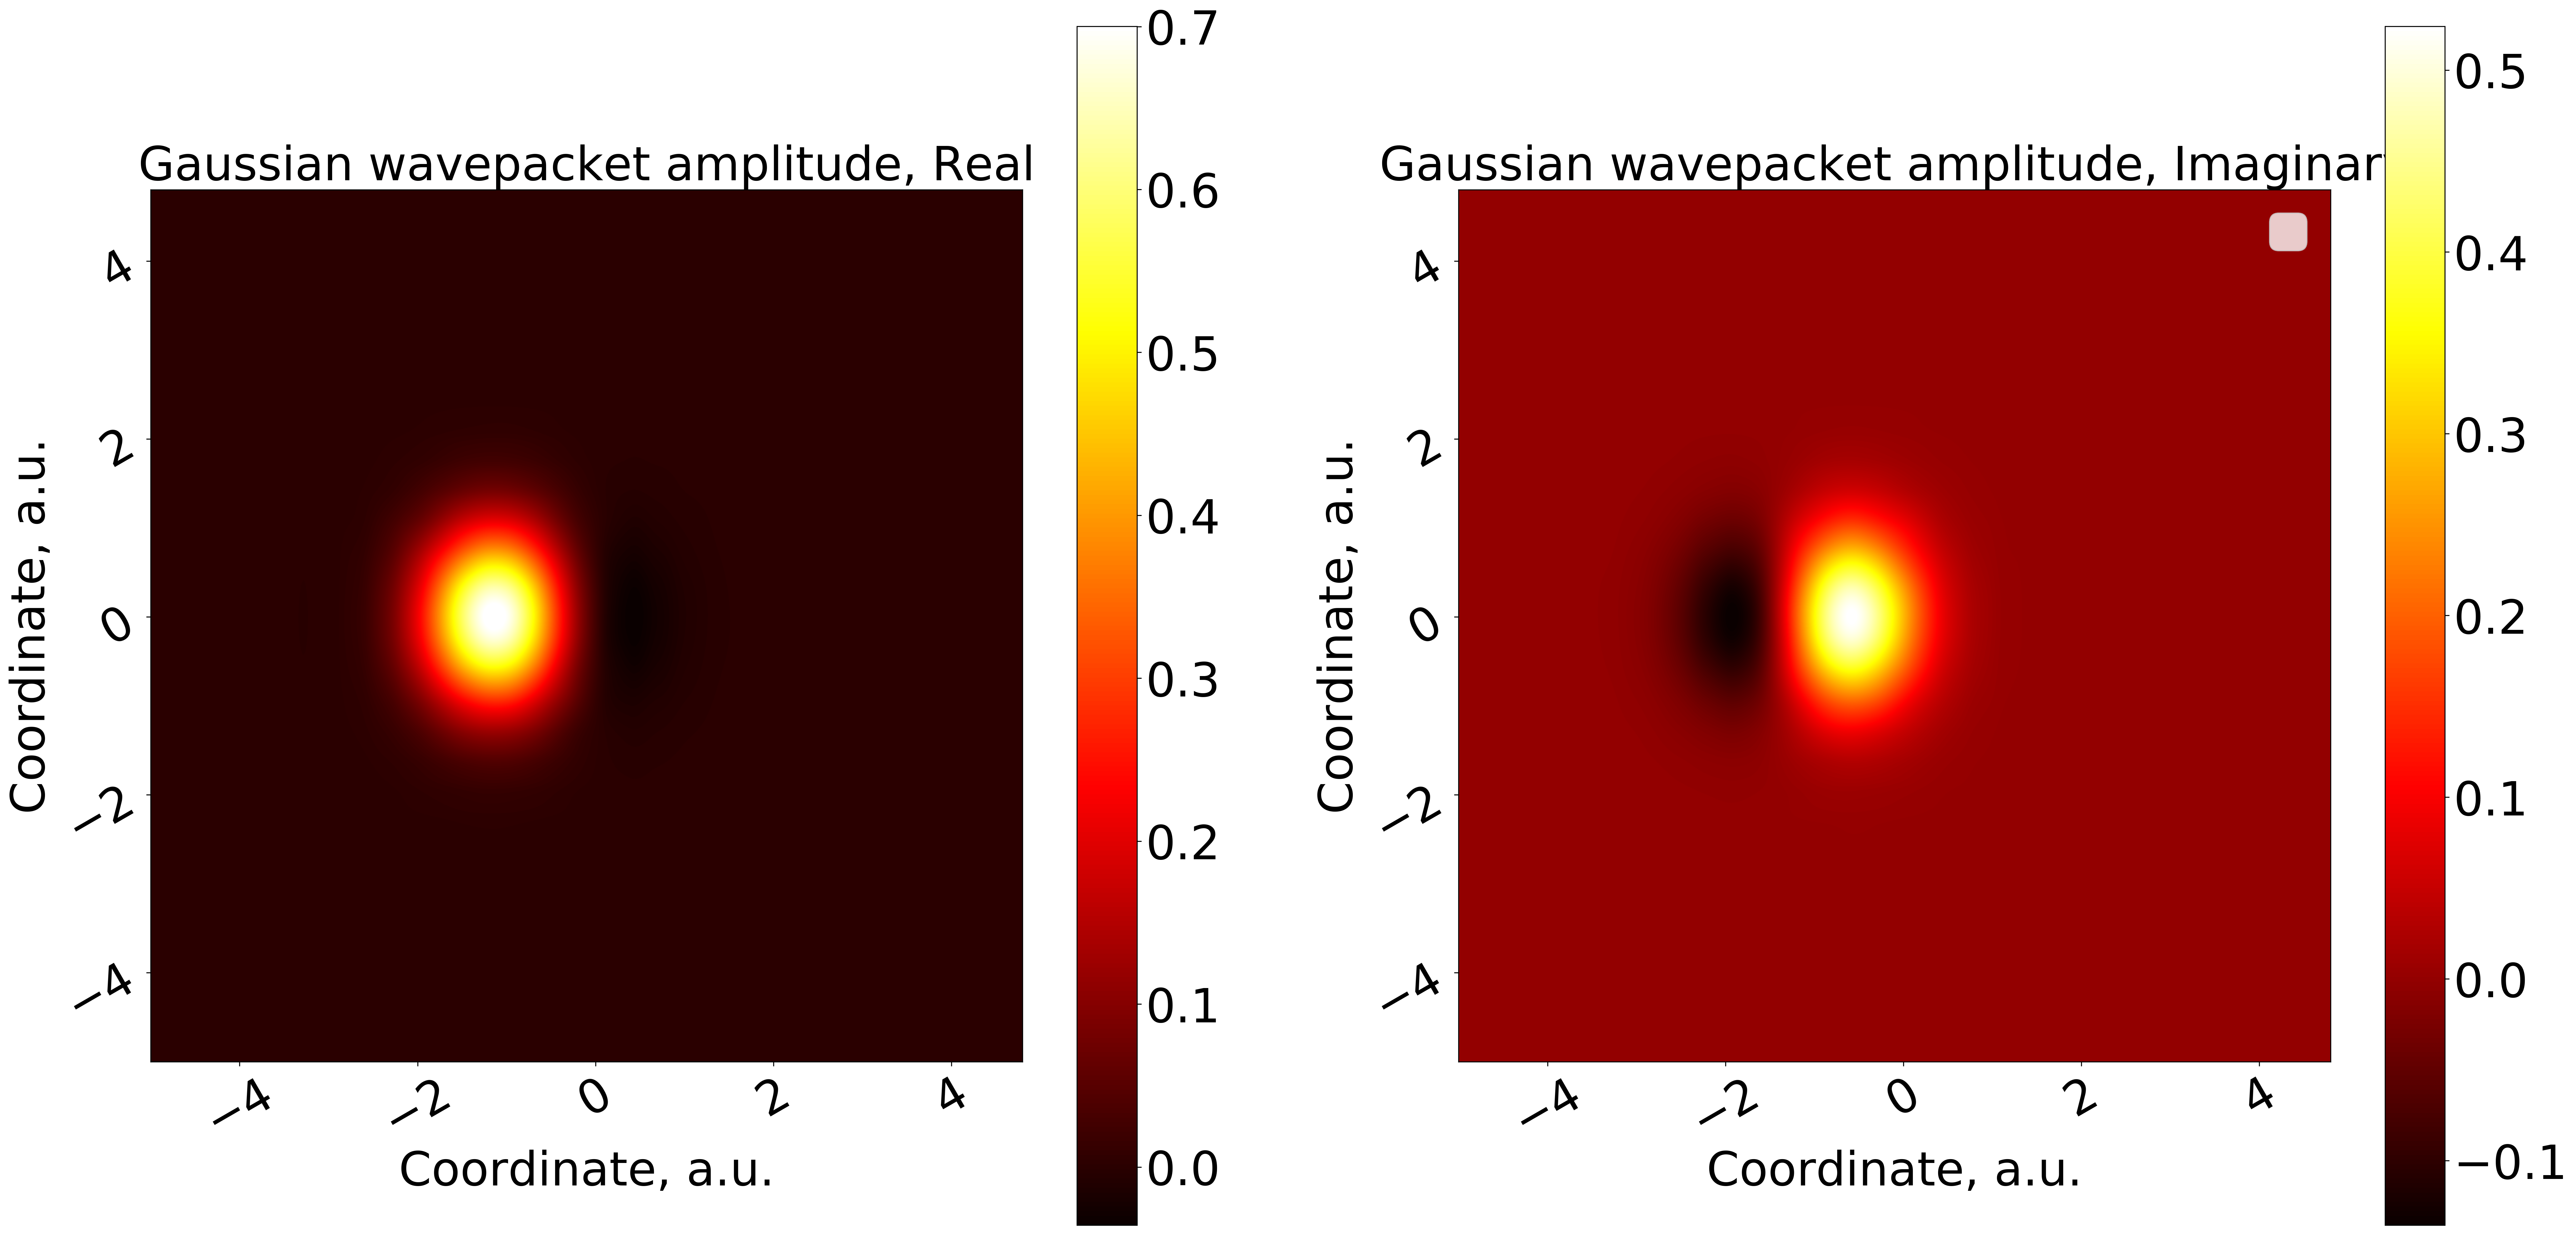

In [6]:
plt.figure(1, figsize=(36, 18), dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('Gaussian wavepacket amplitude, Real')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Coordinate, a.u.')
data_visualize.plot_map(plt, x_grid, y_grid, g_re, "hot", 30j )

plt.subplot(1,2,2)
plt.title('Gaussian wavepacket amplitude, Imaginary')
plt.xlabel('Coordinate, a.u.')
plt.ylabel('Coordinate, a.u.')
data_visualize.plot_map(plt, x_grid, y_grid, g_im, "hot", 30j )

plt.legend()
plt.show()
plt.close()

### 3. Computing overlaps of Gaussian wavepackets with `gwp_overlap` function
<a name="gwp_overlap"></a>[Back to TOC](#TOC)

This function computes the overlap:

$ < G_1 | G_2 >$, 

where:

$G_1 = G_1(r; R_1, P_1, \alpha, \gamma_1) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_1)^2 + \frac{i P_1}{\hbar} (r-R_1) + \frac{i \gamma_1}{\hbar}]$

$G_2 = G_2(r; R_2, P_2, \alpha, \gamma_2) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_2)^2 + \frac{i P_2}{\hbar} (r-R_2) + \frac{i \gamma_2}{\hbar}]$

It follows the C++ signature:

    complex<double> gwp_overlap(MATRIX& R1, MATRIX& P1, double gamma1, 
                            MATRIX& R2, MATRIX& P2, double gamma2, 
                            double alp, double hbar)
       
The parameters are as follows:

  * `R1` and `R2` (MATRIX(Ndof x 1)) - multidimensional coordinates of the centers of the Gaussians. 
  * `P1` and `P2` (MATRIX(Ndof x 1)) - multidimensional momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` (double) - phases of the overall Gaussians
  * `alp` (double) - the Gaussian width factor. Assumed to be the same for each Gaussian 
  * `hbar` (double) - the Planck constant in selected units

  The function returns the value of the overlap of the two Gaussian functions - a complex number
  
Look for derivations [here](https://github.com/alexvakimov/Derivatory/blob/master/Gaussian_wavepackets.pdf)


Lets compute overlap between two GWPs as a function of their relative position

<a name="gwp_overlap_function"></a>

In [7]:
hbar = 1.0
alpha = 1.0
gamma1, gamma2 = 0.5, 0.5

P1 = MATRIX(1,1); P1.set(0, 0, 1.0)
R1 = MATRIX(1,1); R1.set(0, 0, 0.0)

P2 = MATRIX(1,1); P2.set(0, 0, 1.0)
R2 = MATRIX(1,1); R2.set(0, 0, 0.0)


x_grid = []
for i in range(200):
    x_grid.append(-10.0 + 0.1*i)
    
ovlp_re, ovlp_im = [], []
for x in x_grid:
    R2.set(0, 0, x)
    s_val = gwp_overlap(R1, P1, gamma1, R2, P2, gamma2, alpha, hbar)
    ovlp_re.append( s_val.real )
    ovlp_im.append( s_val.imag )
    

Now plot it:

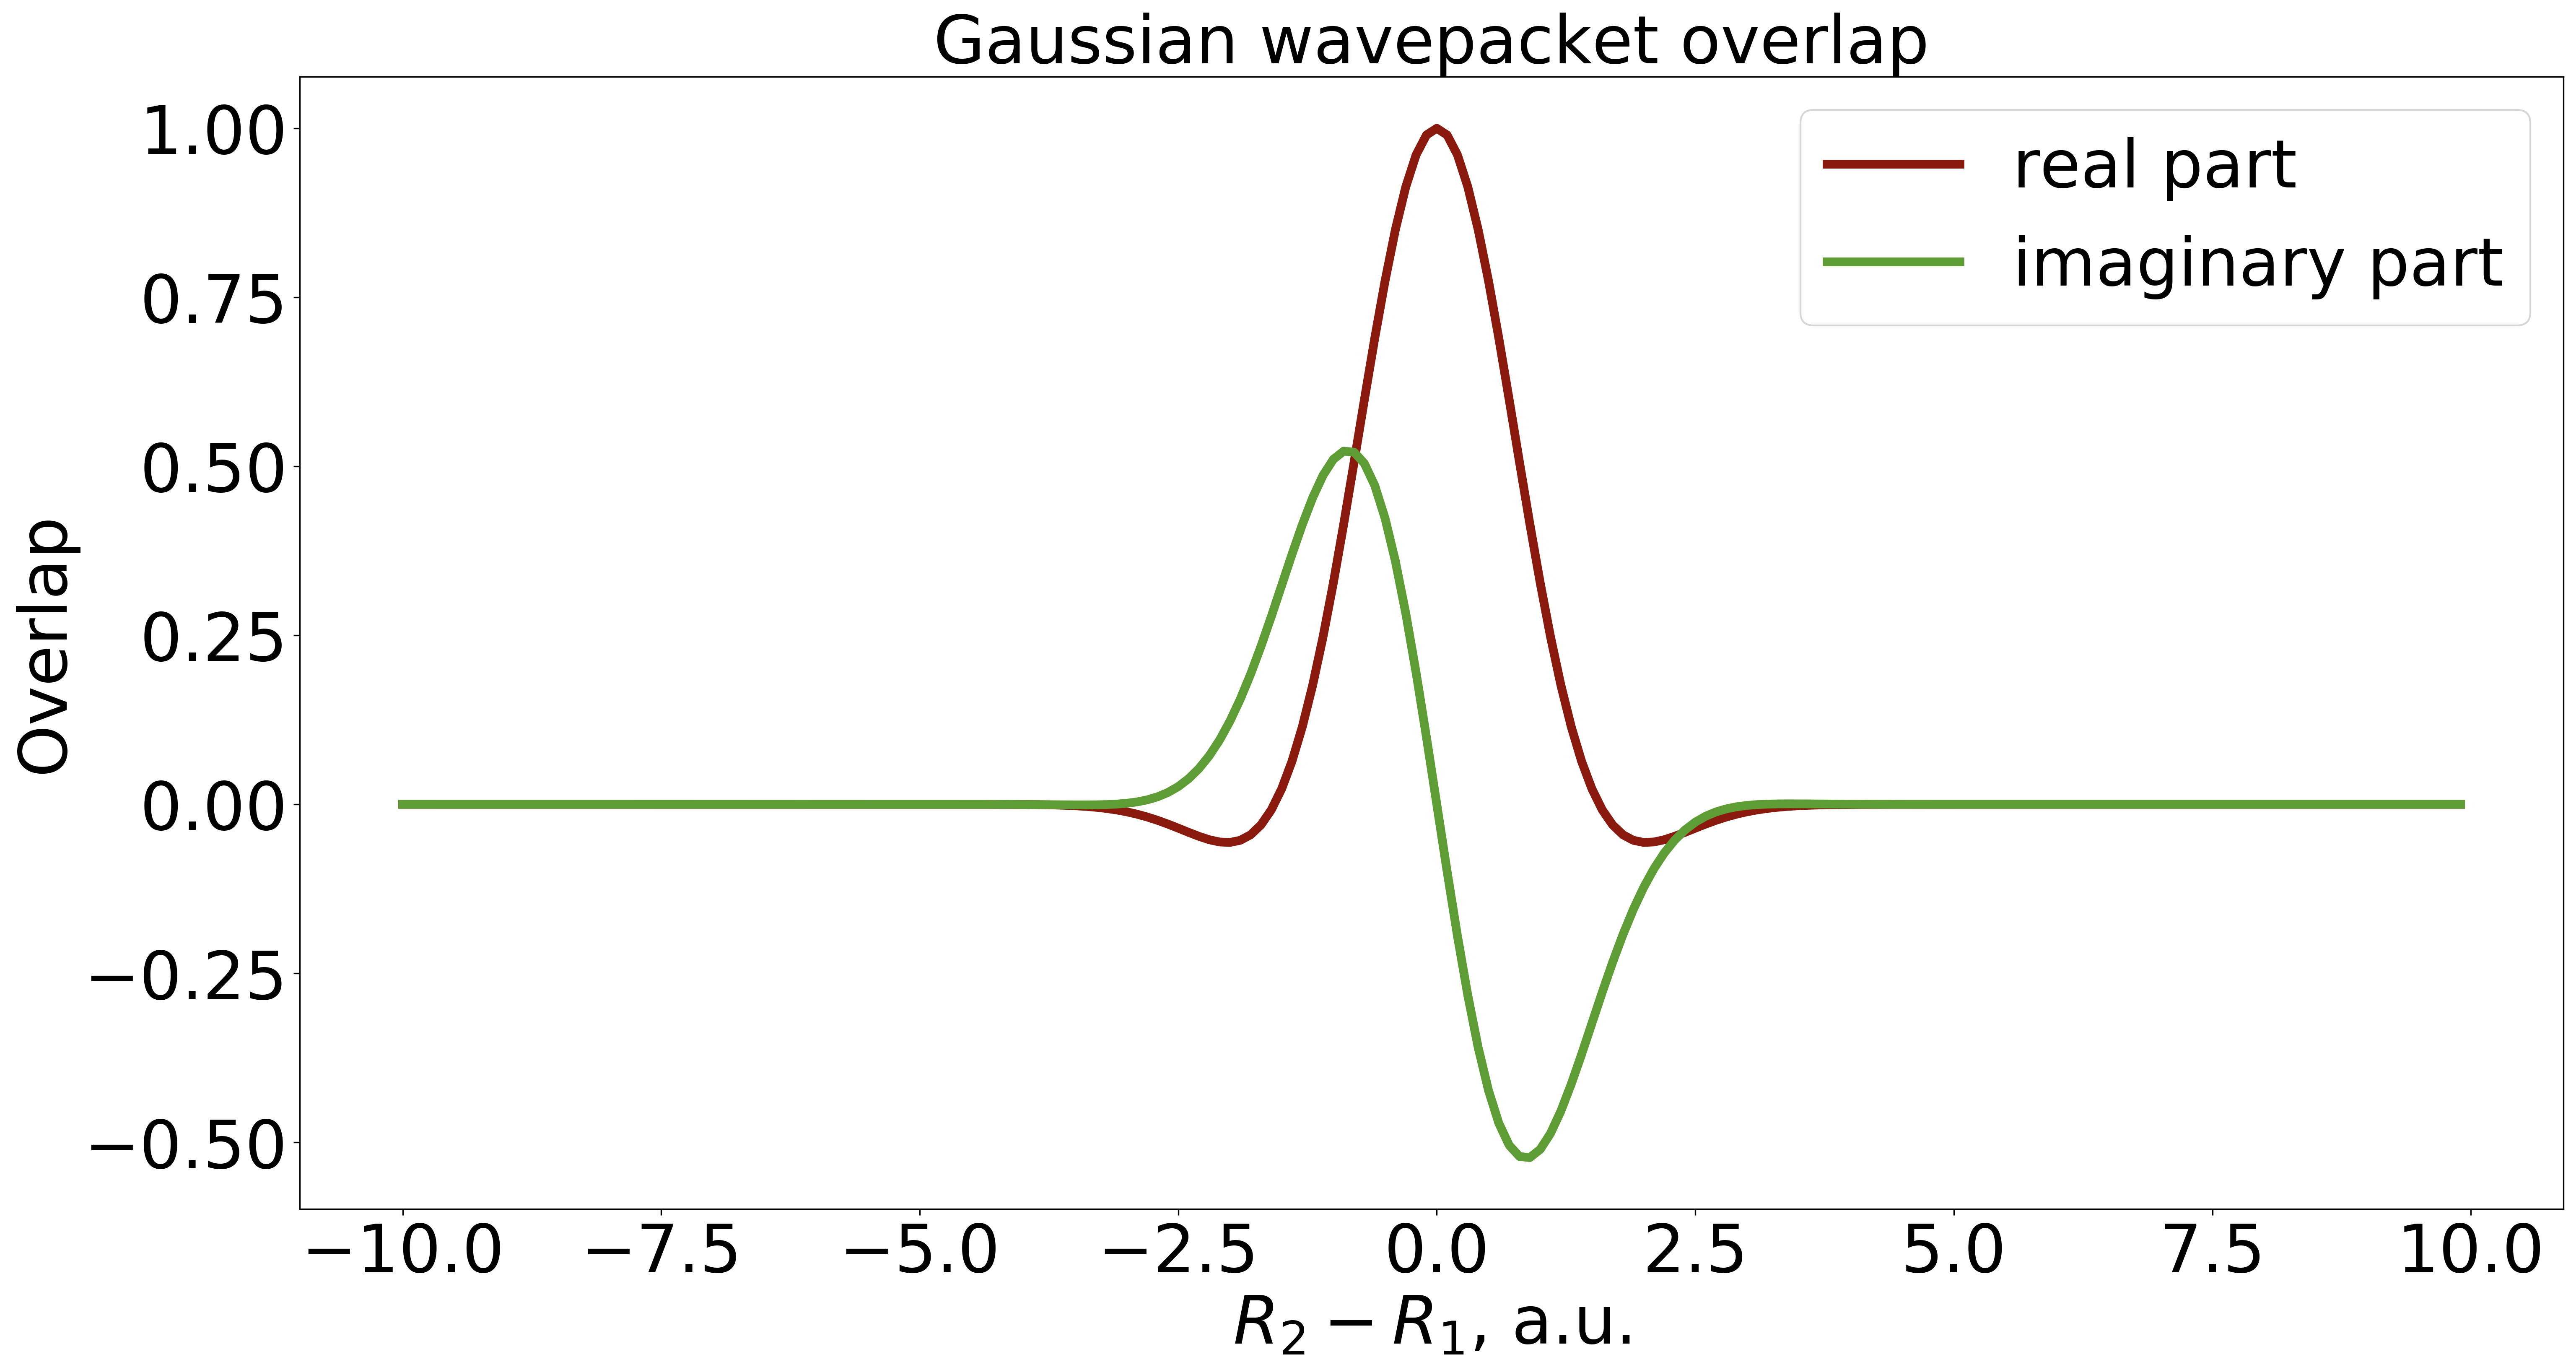

In [8]:
plt.figure(2, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Gaussian wavepacket overlap')
plt.xlabel('$R_2-R_1$, a.u.')
plt.ylabel('Overlap')

plt.plot(x_grid, ovlp_re , label='real part', linewidth=5, color = colors["11"]) 
plt.plot(x_grid, ovlp_im , label='imaginary part', linewidth=5, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()

### Exercise 2
Play around with the parameters of the wavepacket:
* $\alpha$ (`alp`)
* $\gamma_1$ (`gamma1`) and $\gamma_2$ (`gamma2`)
* $P_1$ (`P1`) and $P_2$ (`P2`)

How does the overlap depend on these parameters qualitatively?

### Exercise 3
Note how the overlap is 1 and is real for $|R_1-R_2|=0$. Does this still hold when the parameters of the wavepackets are distinct?

### 4. Computing transition dipole moment with `gwp_dipole` function
<a name="gwp_dipole"></a>[Back to TOC](#TOC)

This function computes the transition dipole moment matrix elements, for each DOF of the vector $r$:

$ < G_1 | r | G_2 >$, 

where:

$G_1(r) = G_1(r; R_1, P_1, \alpha, \gamma_1) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_1)^2 + \frac{i P_1}{\hbar} (r-R_1) + \frac{i \gamma_1}{\hbar}]$

$G_2(r) = G_2(r; R_2, P_2, \alpha, \gamma_2) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_2)^2 + \frac{i P_2}{\hbar} (r-R_2) + \frac{i \gamma_2}{\hbar}]$

It follows the C++ signature:

    CMATRIX gwp_dipole(MATRIX& R1, MATRIX& P1, double gamma1, 
                       MATRIX& R2, MATRIX& P2, double gamma2, 
                       double alp, double hbar)
       
The parameters are as follows:

  * `R1` and `R2` (MATRIX(Ndof x 1)) - multidimensional coordinates of the centers of the Gaussians. 
  * `P1` and `P2` (MATRIX(Ndof x 1)) - multidimensional momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` (double) - phases of the overall Gaussians
  * `alp` (double) - the Gaussian width factor. Assumed to be the same for each Gaussian 
  * `hbar` (double) - the Planck constant in selected units

  The function returns the value of the transition dipole moment matrix elements with the two Gaussian functions - a list of complex numbers - one per each DOF. 
  
Look for derivations [here](https://github.com/alexvakimov/Derivatory/blob/master/Gaussian_wavepackets.pdf)


Lets compute the $ < G_1 | r | G_2 >$ matrix elements for two GWPs as a function of their relative position.

Note that the returned result is a vector, whose dimensionality is equal to the dimensionality of the problem. In this case, the dimensionality is 1, so we only extract the $< G_1 | x | G_2 >$ components.

<a name="gwp_dipole_function"></a>

In [9]:
hbar = 1.0
alpha = 1.0
gamma1, gamma2 = 0.5, 0.5

P1 = MATRIX(1,1); P1.set(0, 0, 1.0)
R1 = MATRIX(1,1); R1.set(0, 0, 0.0)

P2 = MATRIX(1,1); P2.set(0, 0, 1.0)
R2 = MATRIX(1,1); R2.set(0, 0, 0.0)


x_grid = []
for i in range(200):
    x_grid.append(-10.0 + 0.1*i)
    
mu_re, mu_im = [], []
for x in x_grid:
    R2.set(0, 0, x)
    mu_val = gwp_dipole(R1, P1, gamma1, R2, P2, gamma2, alpha, hbar).get(0,0)
    mu_re.append( mu_val.real )
    mu_im.append( mu_val.imag )


Now plot it:

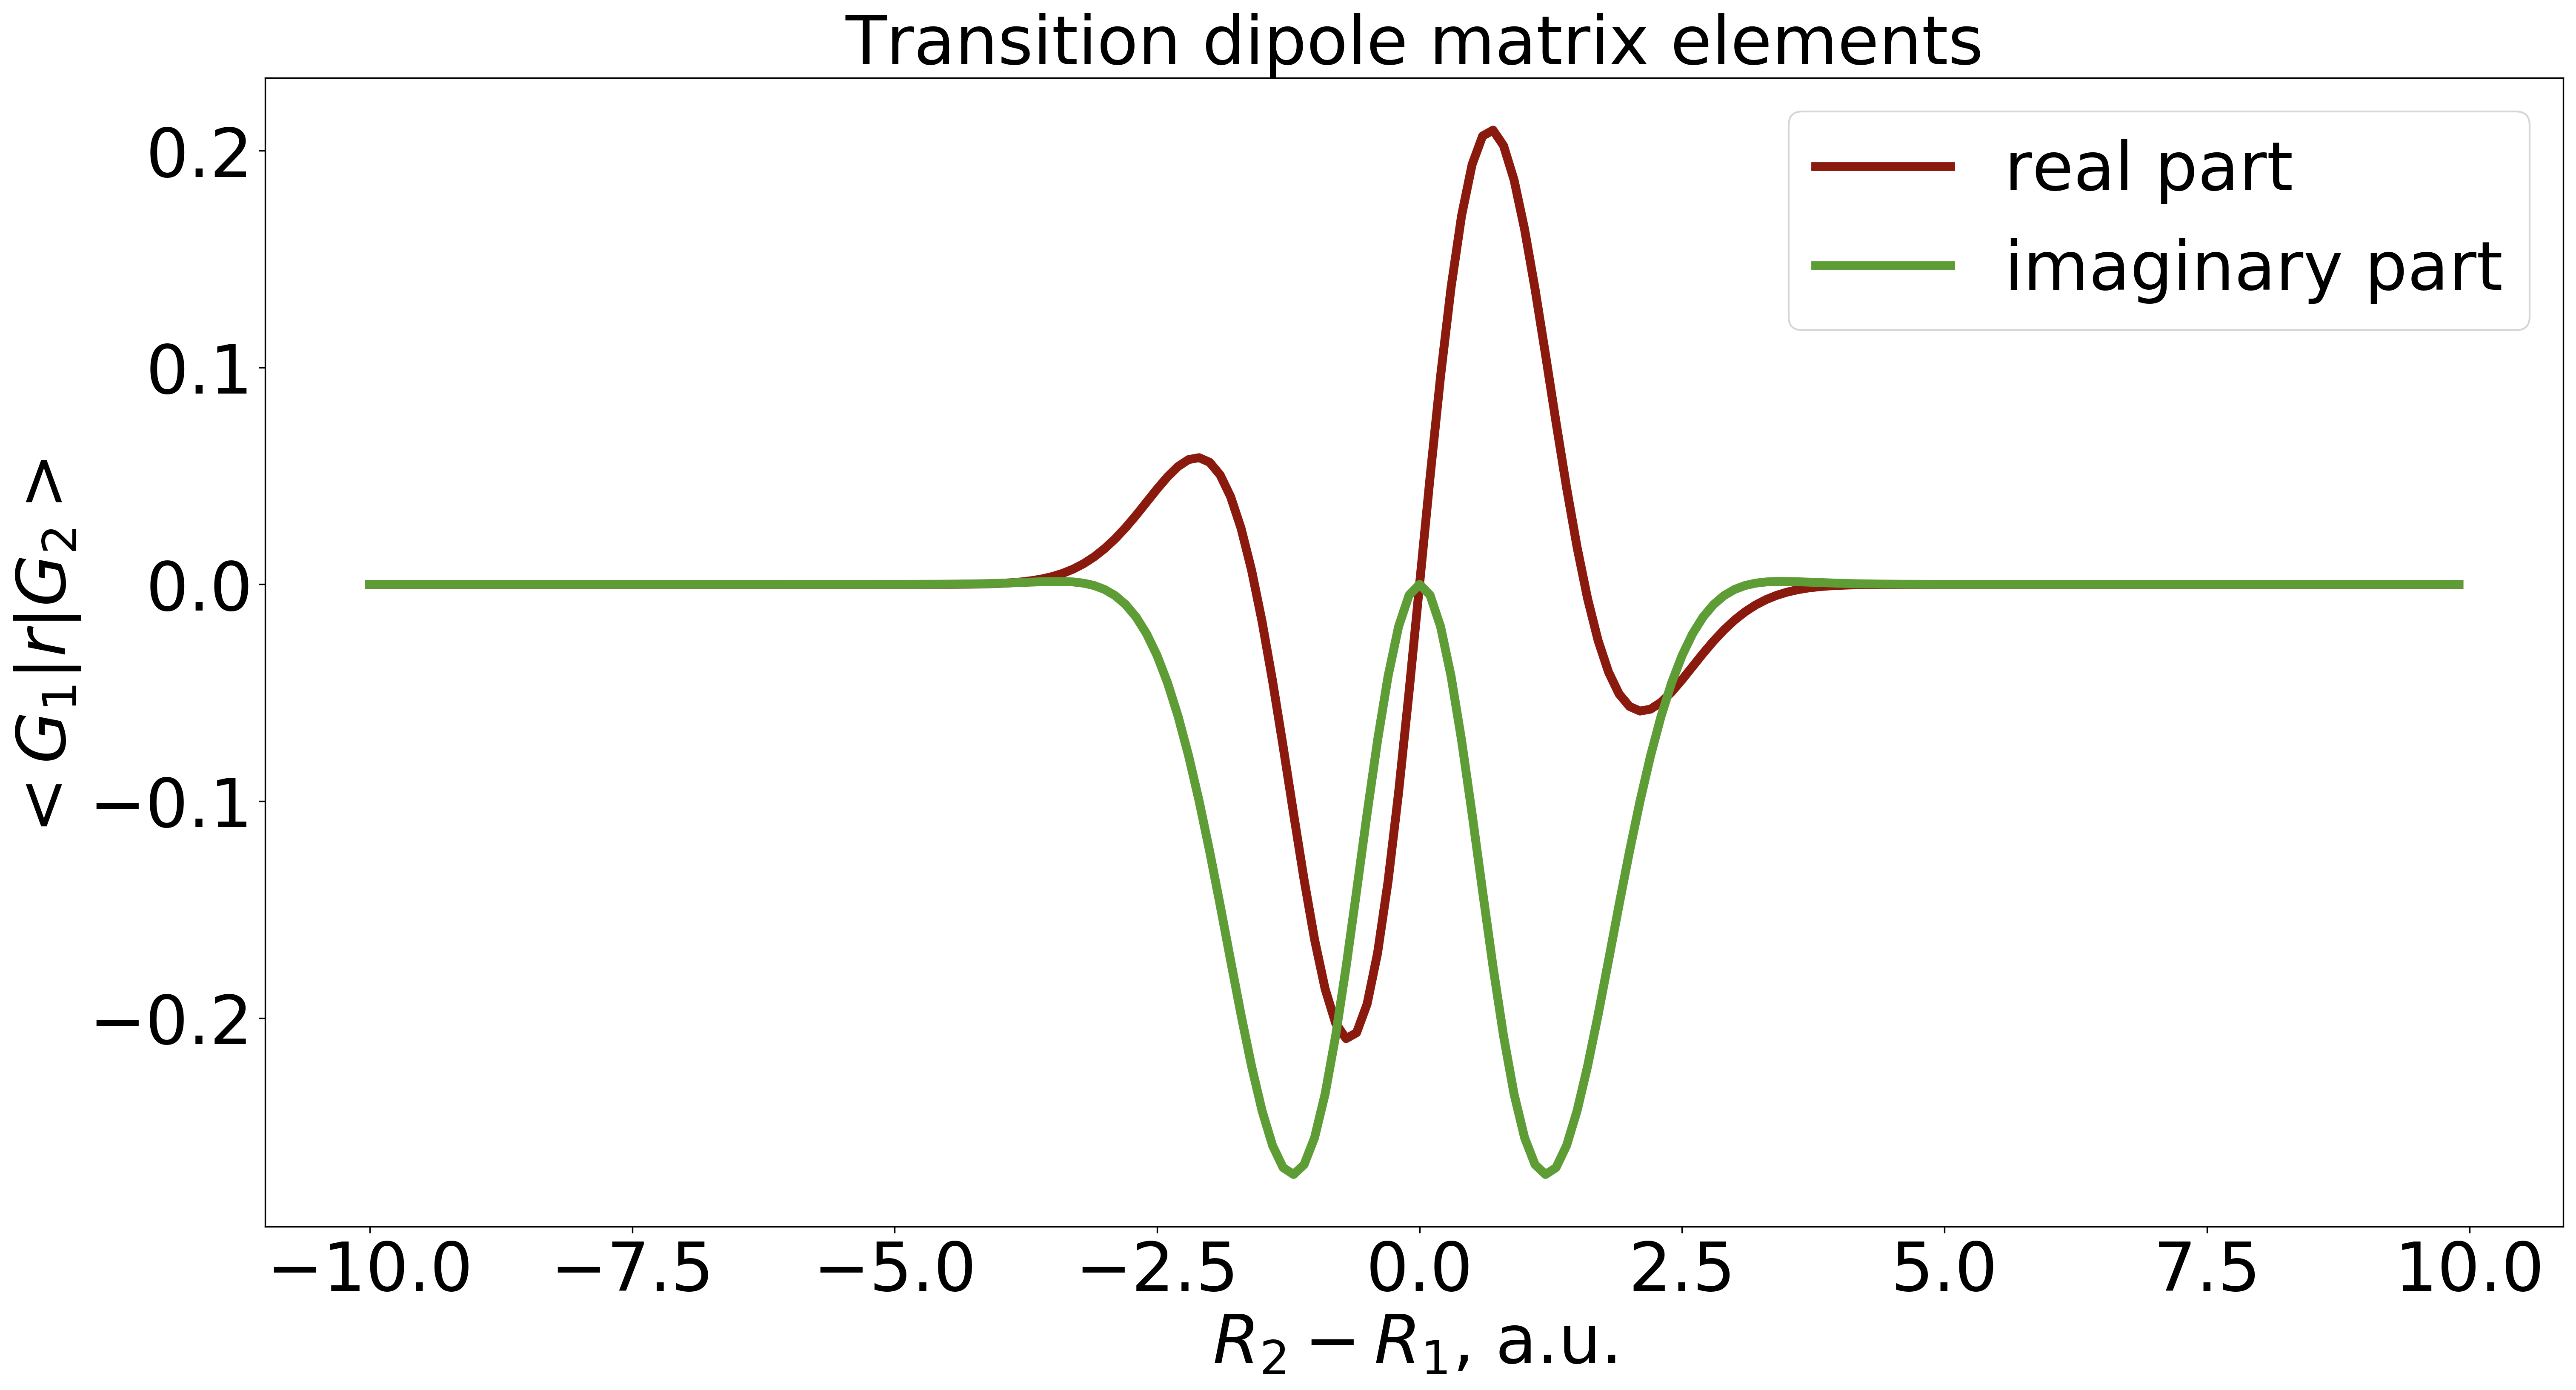

In [10]:
plt.figure(3, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Transition dipole matrix elements')
plt.xlabel('$R_2-R_1$, a.u.')
plt.ylabel('$ < G_1 | r | G_2 >$')

plt.plot(x_grid, mu_re , label='real part', linewidth=5, color = colors["11"]) 
plt.plot(x_grid, mu_im , label='imaginary part', linewidth=5, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()

### 5. Computing derivative coupling matrix elements with `gwp_coupling` function
<a name="gwp_coupling"></a>[Back to TOC](#TOC)

This function computes the derivative coupling matrix elements, for each DOF of the vector $r$:

$ < G_1 | \nabla_r | G_2 >$, 

where:

$G_1(r) = G_1(r; R_1, P_1, \alpha, \gamma_1) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_1)^2 + \frac{i P_1}{\hbar} (r-R_1) + \frac{i \gamma_1}{\hbar}]$

$G_2(r) = G_2(r; R_2, P_2, \alpha, \gamma_2) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_2)^2 + \frac{i P_2}{\hbar} (r-R_2) + \frac{i \gamma_2}{\hbar}]$

It follows the C++ signature:

    CMATRIX gwp_coupling(MATRIX& R1, MATRIX& P1, double gamma1, 
                         MATRIX& R2, MATRIX& P2, double gamma2, 
                         double alp, double hbar)
       
The parameters are as follows:

  * `R1` and `R2` (MATRIX(Ndof x 1)) - multidimensional coordinates of the centers of the Gaussians. 
  * `P1` and `P2` (MATRIX(Ndof x 1)) - multidimensional momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` (double) - phases of the overall Gaussians
  * `alp` (double) - the Gaussian width factor. Assumed to be the same for each Gaussian 
  * `hbar` (double) - the Planck constant in selected units

  The function returns the value of the derivative coupling matrix elements with the two Gaussian functions - a list of complex numbers - one per each DOF. 
  
Look for derivations [here](https://github.com/alexvakimov/Derivatory/blob/master/Gaussian_wavepackets.pdf)


Lets compute the $ < G_1 | \nabla_r | G_2 >$ matrix elements for two GWPs as a function of their relative position.

Note that the returned result is a vector, whose dimensionality is equal to the dimensionality of the problem. In this case, the dimensionality is 1, so we only extract the $< G_1 | \frac{d}{dx} | G_2 >$ components.

<a name="gwp_coupling_function"></a>

In [11]:
hbar = 1.0
alpha = 1.0
gamma1, gamma2 = 0.5, 0.5

P1 = MATRIX(1,1); P1.set(0, 0, 1.0)
R1 = MATRIX(1,1); R1.set(0, 0, 0.0)

P2 = MATRIX(1,1); P2.set(0, 0, 1.0)
R2 = MATRIX(1,1); R2.set(0, 0, 0.0)


x_grid = []
for i in range(200):
    x_grid.append(-10.0 + 0.1*i)
    
dc_re, dc_im = [], []
for x in x_grid:
    R2.set(0, 0, x)
    dc_val = gwp_coupling(R1, P1, gamma1, R2, P2, gamma2, alpha, hbar).get(0,0)
    dc_re.append( dc_val.real )
    dc_im.append( dc_val.imag )


Now, plot it:

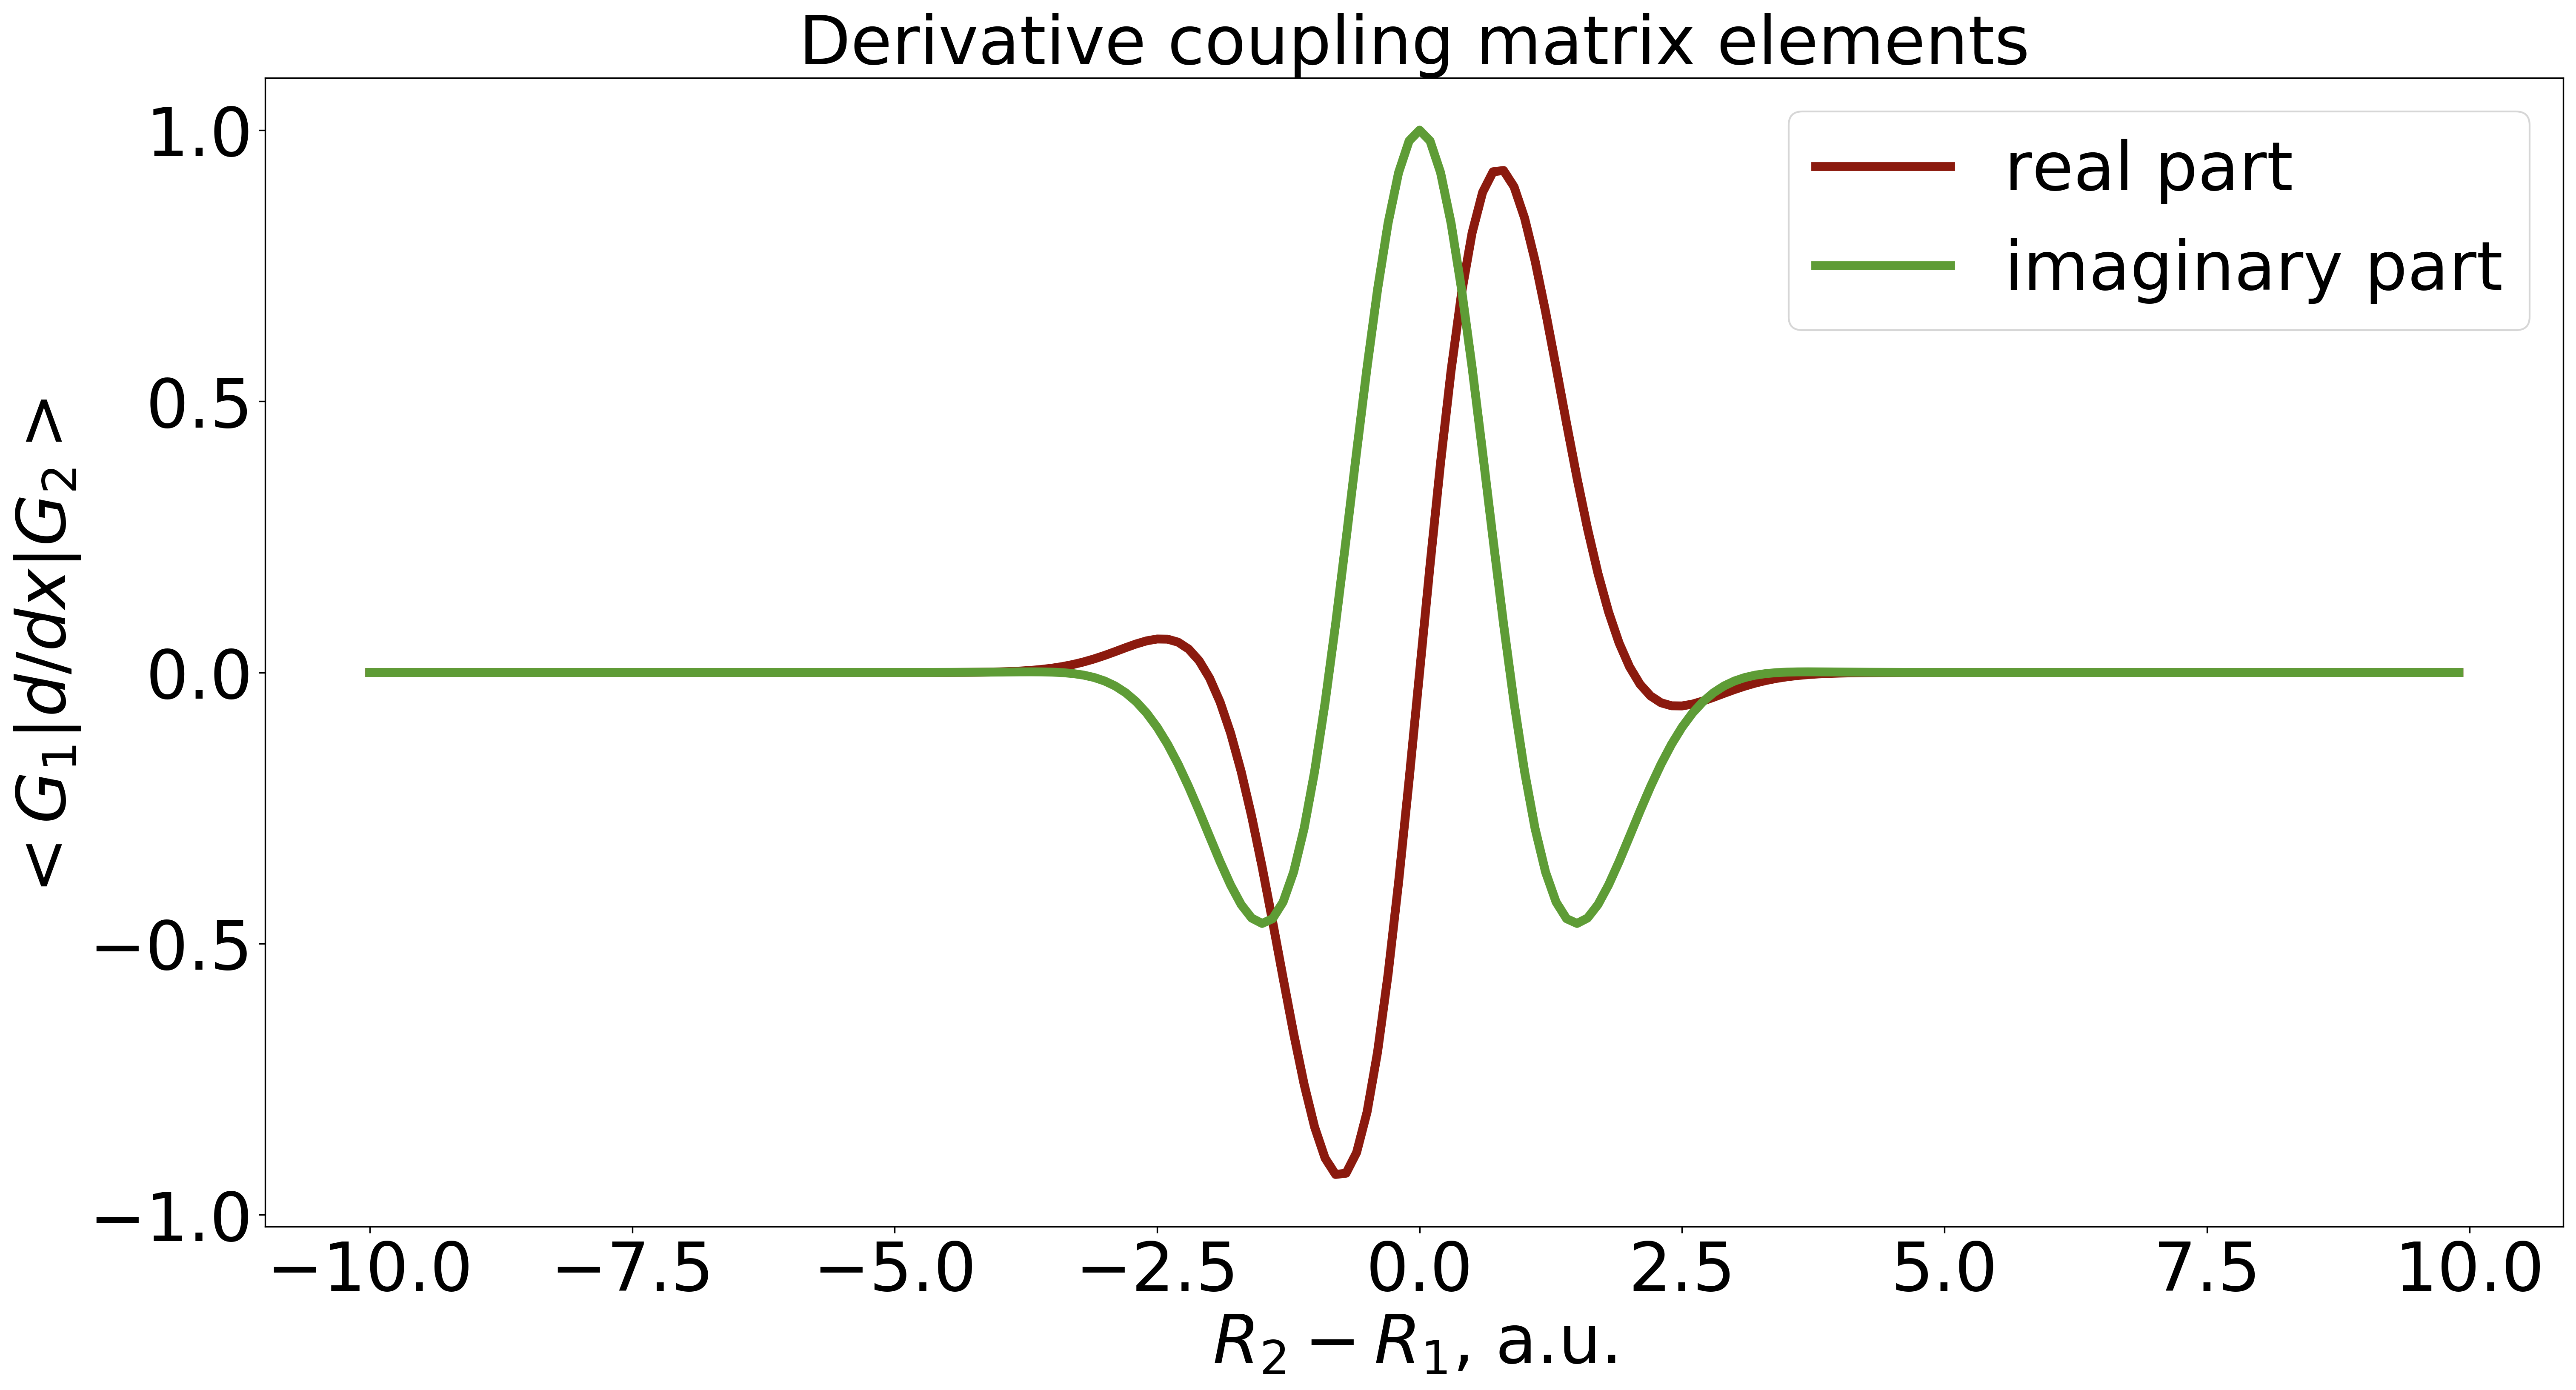

In [12]:
plt.figure(3, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Derivative coupling matrix elements')
plt.xlabel('$R_2-R_1$, a.u.')
plt.ylabel('$ < G_1 | d/dx | G_2 > $')

plt.plot(x_grid, dc_re , label='real part', linewidth=5, color = colors["11"]) 
plt.plot(x_grid, dc_im , label='imaginary part', linewidth=5, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()

### 6. Computing the kinetic energy matrix elements with `gwp_kinetic` function
<a name="gwp_kinetic"></a>[Back to TOC](#TOC)

This function computes the kinetic energy matrix elements (up to a constant):

$ < G_1 | \nabla_r^2 | G_2 >$, 

where:

$G_1(r) = G_1(r; R_1, P_1, \alpha, \gamma_1) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_1)^2 + \frac{i P_1}{\hbar} (r-R_1) + \frac{i \gamma_1}{\hbar}]$

$G_2(r) = G_2(r; R_2, P_2, \alpha, \gamma_2) = (\frac{2 \alpha}{\pi})^{\frac{Ndof}{4}} exp[-\alpha (r-R_2)^2 + \frac{i P_2}{\hbar} (r-R_2) + \frac{i \gamma_2}{\hbar}]$

It follows the C++ signature:

    complex<double> gwp_coupling(MATRIX& R1, MATRIX& P1, double gamma1, 
                                 MATRIX& R2, MATRIX& P2, double gamma2, 
                                 double alp, double hbar)
       
The parameters are as follows:

  * `R1` and `R2` (MATRIX(Ndof x 1)) - multidimensional coordinates of the centers of the Gaussians. 
  * `P1` and `P2` (MATRIX(Ndof x 1)) - multidimensional momenta (classical) of the centers of the Gaussians. 
  * `gamma1` and `gamma2` (double) - phases of the overall Gaussians
  * `alp` (double) - the Gaussian width factor. Assumed to be the same for each Gaussian 
  * `hbar` (double) - the Planck constant in selected units

  The function returns the value of the kinetic operator (up to a constant prefactor) matrix elements with two Gaussian functions - a complex number, which includes the summation over all DOFs. 
  
Look for derivations [here](https://github.com/alexvakimov/Derivatory/blob/master/Gaussian_wavepackets.pdf)


Lets compute the $ < G_1 | \nabla_r^2 | G_2 >$ matrix elements for two GWPs as a function of their relative position.

Note that the returned result is a scalar - the summation over all DOFs has been made by the function.

<a name="gwp_kinetic_function"></a>

In [13]:
hbar = 1.0
alpha = 1.0
gamma1, gamma2 = 0.5, 0.5

P1 = MATRIX(1,1); P1.set(0, 0, 1.0)
R1 = MATRIX(1,1); R1.set(0, 0, 0.0)

P2 = MATRIX(1,1); P2.set(0, 0, 1.0)
R2 = MATRIX(1,1); R2.set(0, 0, 0.0)


x_grid = []
for i in range(200):
    x_grid.append(-10.0 + 0.1*i)
    
kin_re, kin_im = [], []
for x in x_grid:
    R2.set(0, 0, x)
    kin_val = gwp_kinetic(R1, P1, gamma1, R2, P2, gamma2, alpha, hbar)
    kin_re.append( kin_val.real )
    kin_im.append( kin_val.imag )

Now lets plot it:

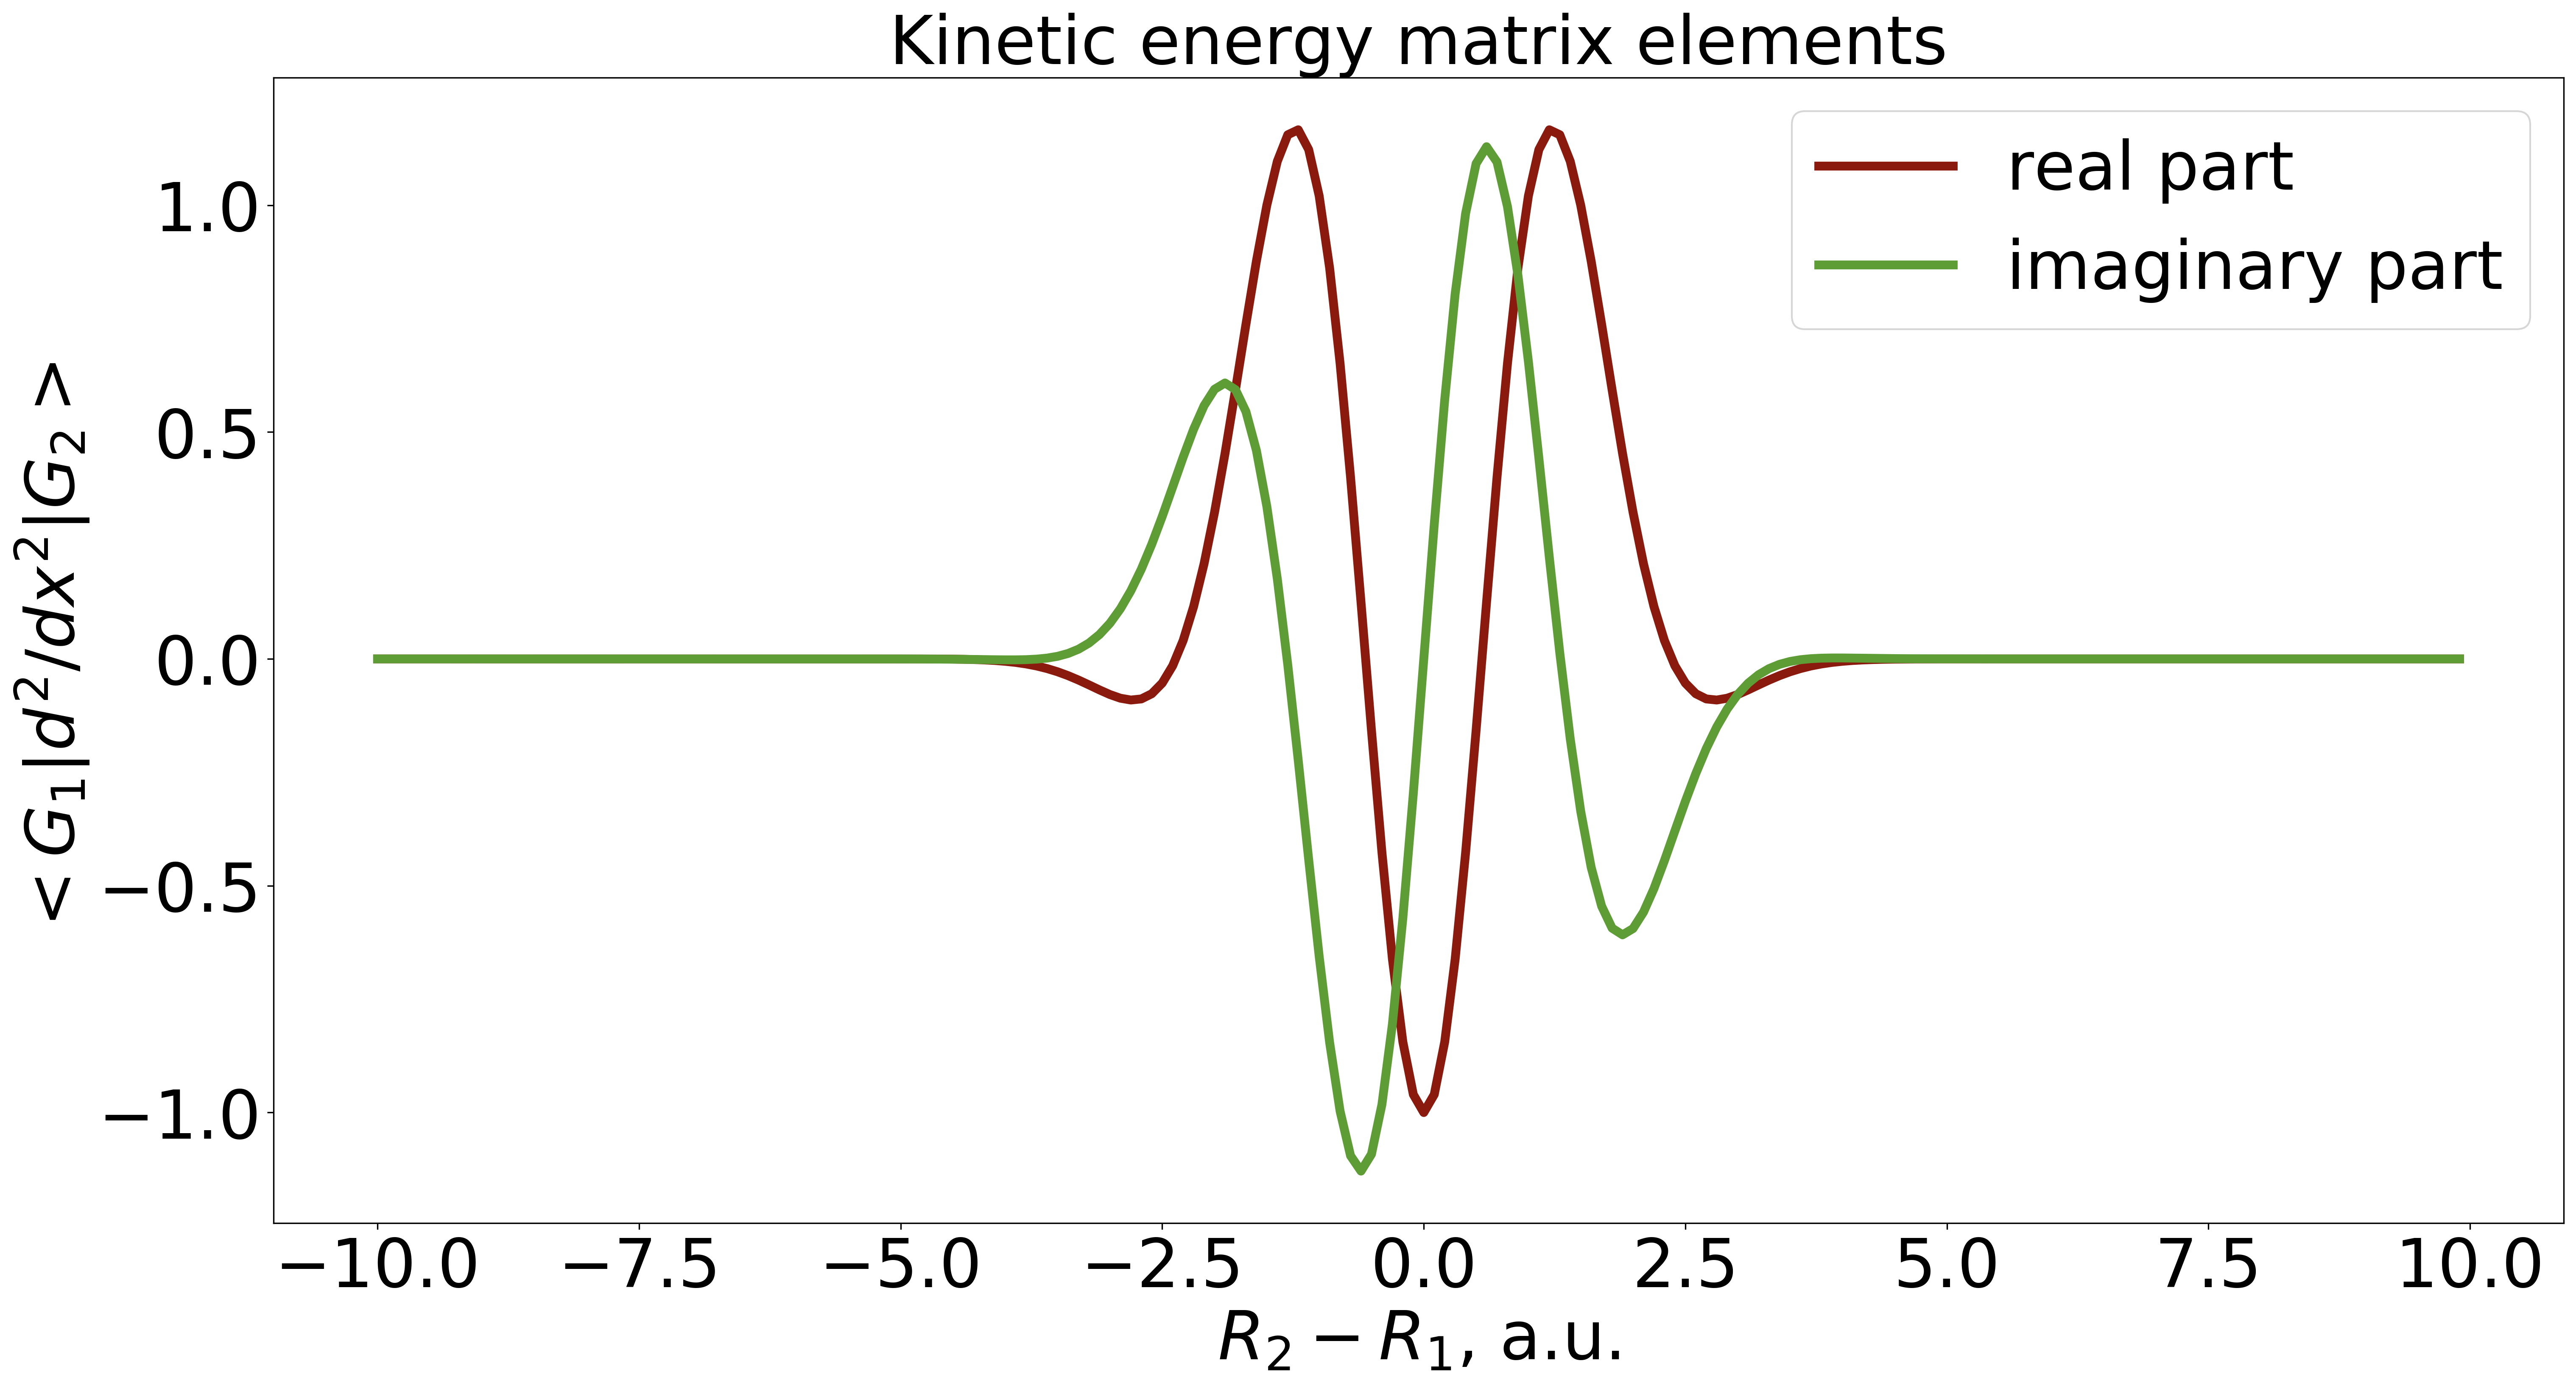

In [14]:
plt.figure(3, figsize=(24, 12), dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Kinetic energy matrix elements')
plt.xlabel('$R_2-R_1$, a.u.')
plt.ylabel('$ < G_1 | d^2/dx^2 | G_2 > $')

plt.plot(x_grid, kin_re , label='real part', linewidth=5, color = colors["11"]) 
plt.plot(x_grid, kin_im , label='imaginary part', linewidth=5, color = colors["21"]) 

plt.legend()
plt.show()
plt.close()

Lets compare the classical kinetic energy and the quantum one.

We consider just a single Gaussian WP, $G = G(r; R, P, \alpha, \gamma)$. 

Its parameter $P$ plays a role of classical momentum, so assuming the particle has a mass of $m = 1$, we can see that the kinetic energy should be:

$ E_{kin}^{class} = \frac{P^2}{2 m}$

The corresponding quantum value would be:

$ E_{kin}^{quant} = -\frac{\hbar^2}{2 m} < G | \frac{d^2}{dx^2} | G > $

Lets compare what we obtain:

In [5]:
hbar = 1.0
alpha = 0.001
gamma = 0.1
mass = 1.0
p = 1.0

print(F"Kinetic energy, classical = {p**2/(2.0*mass)}")

P = MATRIX(1,1); P.set(0, 0, p)
R = MATRIX(1,1); R.set(0, 0, 0.0)

P2 = MATRIX(1,1); P2.set(0, 0, p)
R2 = MATRIX(1,1); R2.set(0, 0, 0.0)

kin_val = gwp_kinetic(R, P, gamma, R2, P2, gamma, alpha, hbar)
print(F"Kinetic energy, quantum = { -hbar**2 * kin_val/(2.0*mass) }")

Kinetic energy, classical = 0.5
Kinetic energy, quantum = (0.5005-0j)


Lets compute the kinetic energy for several other values of the parameter $\alpha$

In [8]:
for alpha in [0.01, 0.1, 1.0, 10.0]:
    kin_val = gwp_kinetic(R, P, gamma, R2, P2, gamma, alpha, hbar)
    print(F"alpha={alpha} Kinetic energy, quantum = { -hbar**2 * kin_val/(2.0*mass) }")

alpha=0.01 Kinetic energy, quantum = (0.505-0j)
alpha=0.1 Kinetic energy, quantum = (0.55-0j)
alpha=1.0 Kinetic energy, quantum = (1-0j)
alpha=10.0 Kinetic energy, quantum = (5.5-0j)


#### Some useful observations

* Note how the quantum kinetic energy approaches the classical kinetic energy as $\alpha ->0 $

* Note how the kinetic energy increases as $\alpha$ increases - this is zero point energy, ZPE - essentially, more and more squizing the wavepacket into a delta-function, means small $\Delta x$ and therefore (according to the uncertainty principle) large $\Delta p_x$, which in turn means large average kinetic energy

* So, thinking of classical particles as a limiting case of Gaussian wavepackets with zero width (delta-functions) is inconsistent with the uncertainty principle. 